<a href="https://colab.research.google.com/github/vedica1011/NLP_BERT_TL/blob/main/finetune_lamma2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q datasets sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00


In [5]:
from google.colab import userdata
hf_token = userdata.get('hugginface_token')

In [12]:
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
from datasets import load_metric
import sentence_transformers
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
datasets = load_dataset("garage-bAInd/Open-Platypus")
datasets

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [10]:
datasets['train'].to_pandas().head()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K


In [15]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [16]:
instruction_tokencount = [len(tokenizer.tokenize(records['instruction']))for records in datasets['train']]
output_tokencount = [len(tokenizer.tokenize(records['output']))for records in datasets['train']]
combine_tokecount = [instruction + output for instruction,output in zip(instruction_tokencount,output_tokencount)]
combine_tokecount[:10]

[308, 158, 268, 182, 522, 247, 370, 116, 368, 308]

In [17]:
def plot_distribution_tokens(token_count,title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(12,6))
  plt.hist(token_count, bins=50,color='#3498db',edgecolor='black')
  plt.xlabel('No of tokens',fontsize=12)
  plt.ylabel('No of examples',fontsize=14)
  plt.title(title)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()


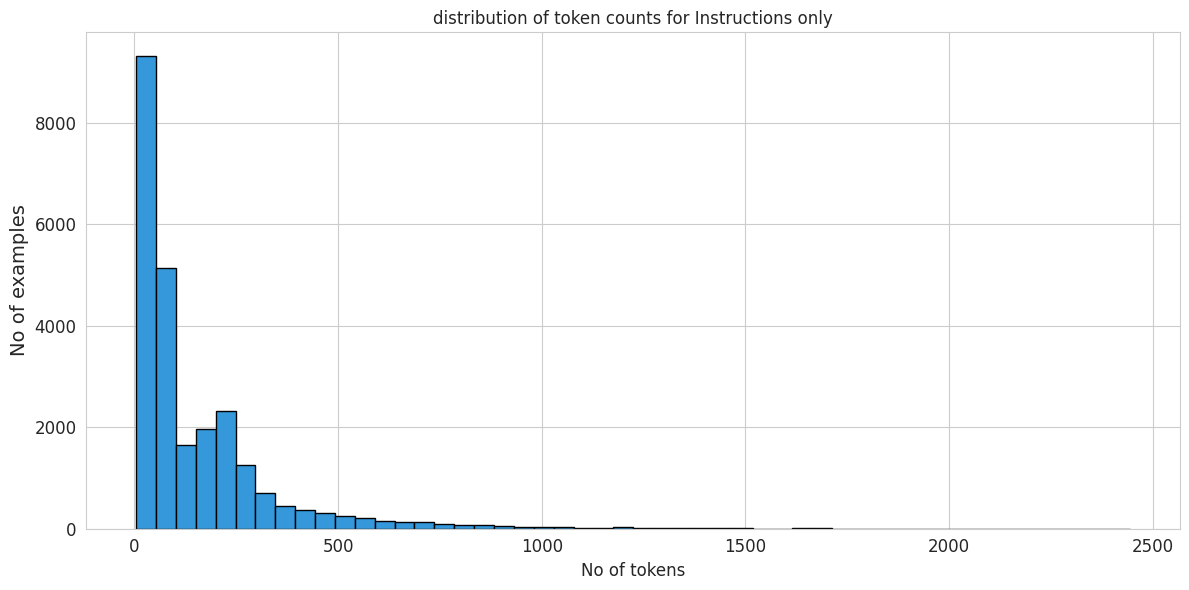

In [18]:
plot_distribution_tokens(instruction_tokencount,'distribution of token counts for Instructions only')

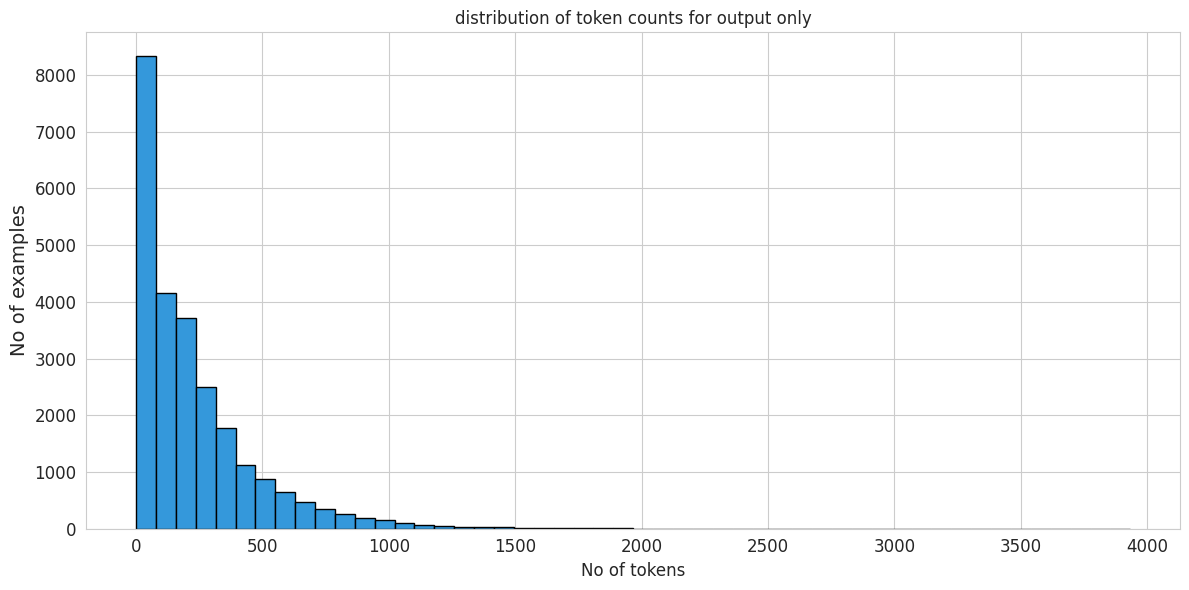

In [19]:
plot_distribution_tokens(output_tokencount,'distribution of token counts for output only')

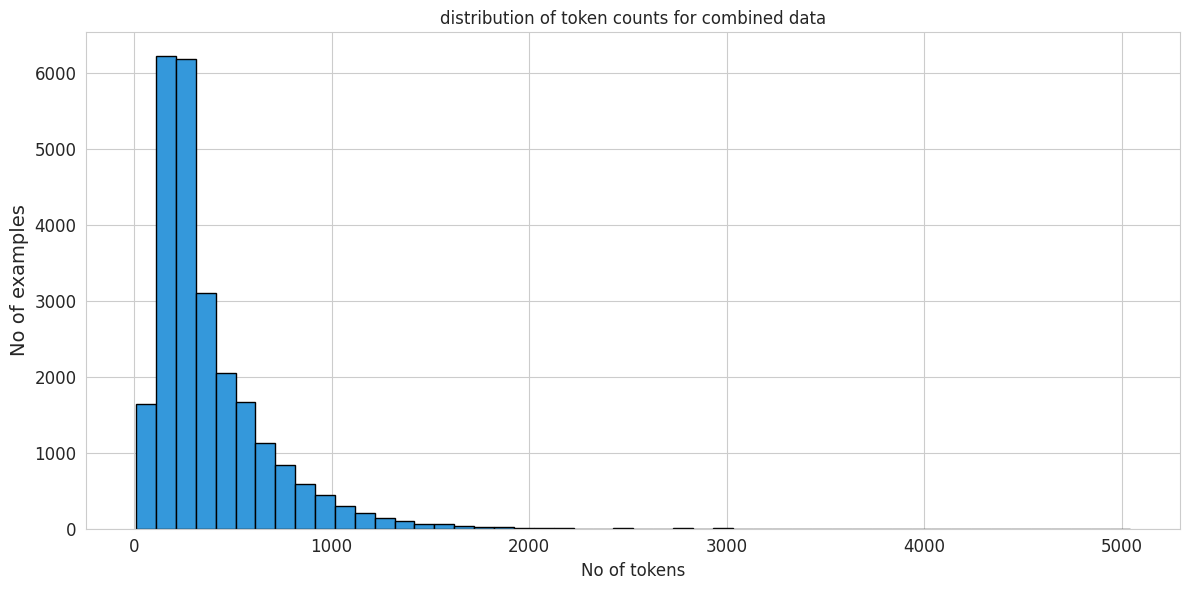

In [21]:
plot_distribution_tokens(combine_tokecount,'distribution of token counts for combined data')

### max context size of llama-2 is 4096 so we will filter our token with 1800 tokens so that we will have tokens for prompt and output

In [29]:
valid_indices = [i for i,tokens in enumerate(combine_tokecount) if tokens <= 1800]
print(len(valid_indices))

24842


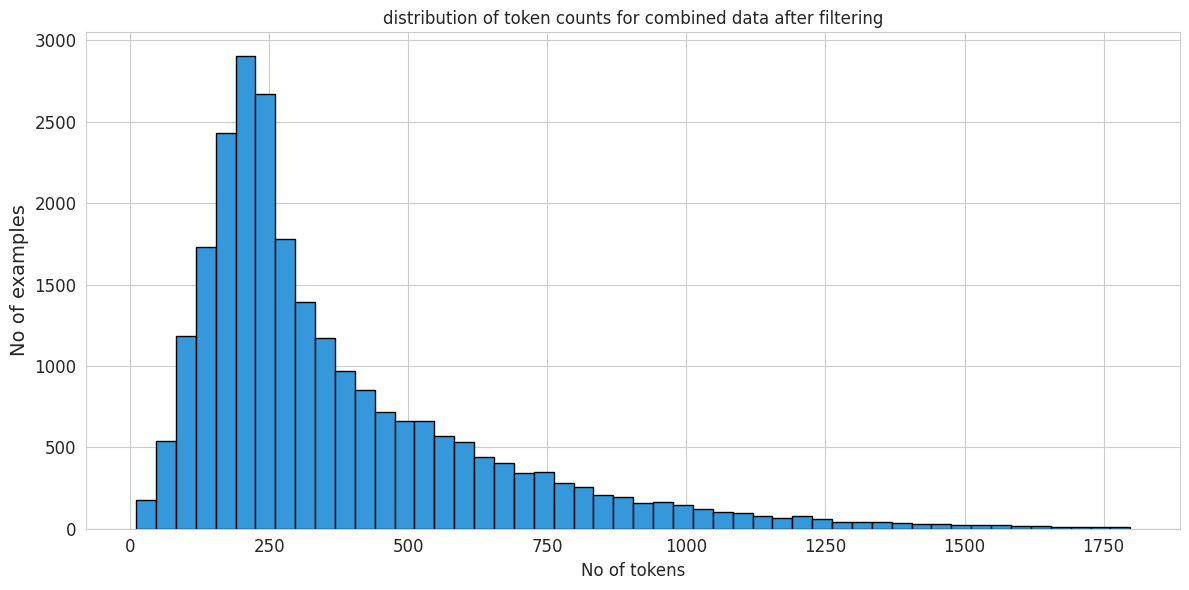

In [30]:
datasets['train'] = datasets['train'].select(valid_indices)
token_counts = [combine_tokecount[i] for i in valid_indices]
plot_distribution_tokens(token_counts,'distribution of token counts for combined data after filtering')